Epoch 1/20


/Users/pranavashokdivekar/this_mac/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0398 - val_loss: 0.0187
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0169 - val_loss: 0.0164
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0160 - val_loss: 0.0156
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0134 - val_loss: 0.0156
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0155 - val_loss: 0.0152
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0130 - val_loss: 0.0147
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0131 - val_loss: 0.0146
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0141 - val_loss: 0.0146
Epoch 9/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0134 - val_loss: 0.0149
Epoch 10/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0138 - val_loss: 0.0150
Epoch 11/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0139 - val_loss: 0.0158
Epoch 12/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


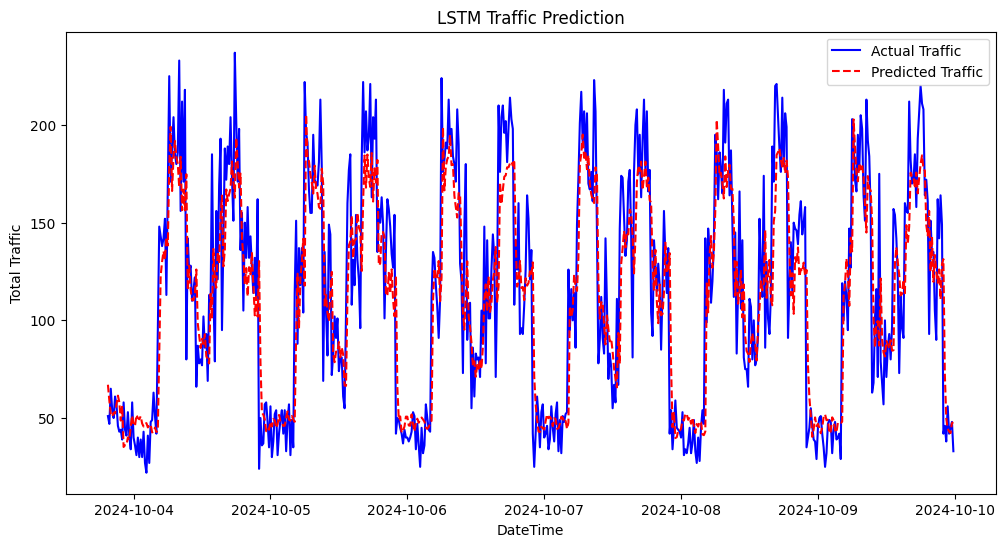

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load dataset
file_path = '/Users/pranavashokdivekar/this_mac/Machine Learning/Traffic.csv'
df = pd.read_csv(file_path)

# Assuming all dates are from October 2024 (modify as per actual data)
df['Date'] = '2024-10-' + df['Date'].astype(str)  # Convert day number to full date
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convert to datetime


df['Time'] = pd.to_datetime(df['Time'], format='%I:%M:%S %p', errors='coerce').dt.time


df['DateTime'] = df.apply(lambda row: pd.Timestamp.combine(row['Date'], row['Time']), axis=1)
df.set_index('DateTime', inplace=True)  # Set as index



# Select features and target
features = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount']
target = 'Total'

# Normalize features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df[target] = scaler.fit_transform(df[[target]])

# Prepare LSTM sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # Features (except target)
        y.append(data[i+seq_length, -1])    # Target (Total traffic count)
    return np.array(X), np.array(y)

seq_length = 10  # Number of past time steps to use
data = df[features + [target]].values
X, y = create_sequences(data, seq_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape input for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], seq_length, len(features)))
X_test = X_test.reshape((X_test.shape[0], seq_length, len(features)))

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, len(features))),
    LSTM(50),
    Dense(25, activation='relu'),
    Dense(1)  # Predicting one value (Total traffic)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Save the trained model
model.save("/Users/pranavashokdivekar/this_mac/Machine Learning/LSTM_Traffic/traffic_model.h5")


# Predict
y_pred = model.predict(X_test)

# Convert back to original scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual Traffic", color='blue')
plt.plot(df.index[-len(y_pred_actual):], y_pred_actual, label="Predicted Traffic", color='red', linestyle='dashed')
plt.xlabel("DateTime")
plt.ylabel("Total Traffic")
plt.legend()
plt.title("LSTM Traffic Prediction")
plt.show()


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

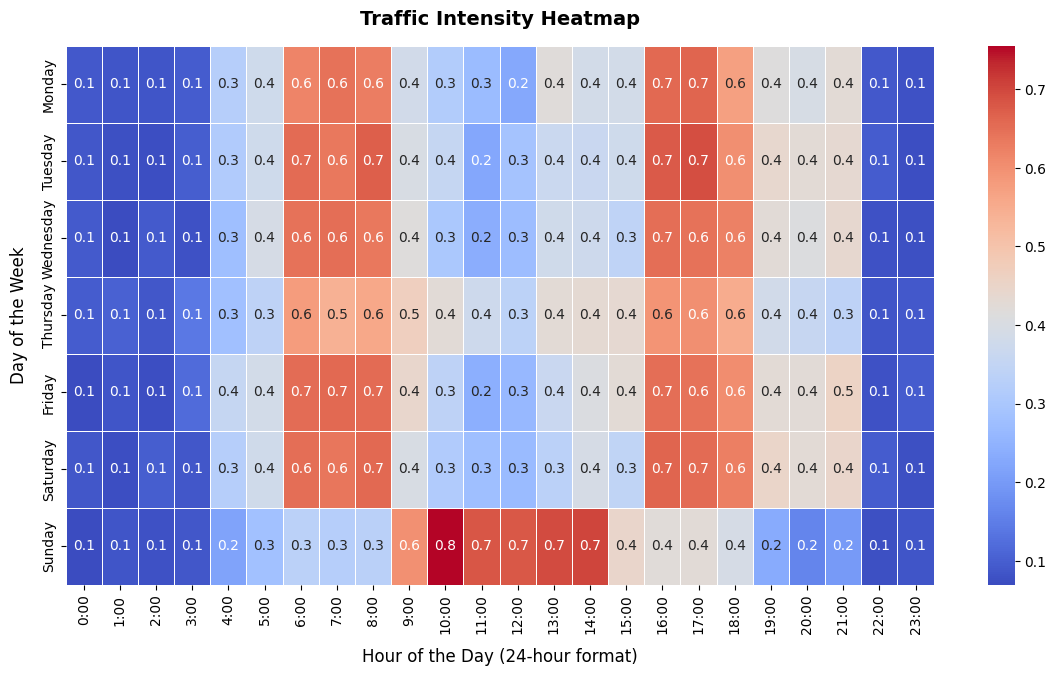

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract hour and weekday information
df['Hour'] = df.index.hour
df['Weekday'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday

# Create a pivot table for heatmap
heatmap_data = df.pivot_table(values='Total', index='Weekday', columns='Hour', aggfunc='mean')

# Define labels for better readability
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hour_labels = [f"{h}:00" for h in range(24)]  # Hourly labels from 0:00 to 23:00

# Plot the heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(
    heatmap_data, cmap='coolwarm', annot=True, fmt=".1f", linewidths=0.5, 
    xticklabels=hour_labels, yticklabels=day_labels
)

# Labels and descriptions
plt.xlabel("Hour of the Day (24-hour format)", fontsize=12, labelpad=10)
plt.ylabel("Day of the Week", fontsize=12, labelpad=10)
plt.title("Traffic Intensity Heatmap", fontsize=14, fontweight="bold", pad=15)

# Add a color bar description
cbar = plt.colorbar()
cbar.set_label("Average Traffic Intensity", fontsize=12)

# Show the heatmap
plt.show()


Epoch 1/20


/Users/pranavashokdivekar/this_mac/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0400 - val_loss: 0.0170
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0167 - val_loss: 0.0188
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0152 - val_loss: 0.0202
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0142 - val_loss: 0.0151
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0147 - val_loss: 0.0169
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0136 - val_loss: 0.0148
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0132 - val_loss: 0.0178
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0143 - val_loss: 0.0144
Epoch 9/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0122 - val_loss: 0.0145
Epoch 10/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0129 - val_loss: 0.0149
Epoch 11/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 12/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.

/Users/pranavashokdivekar/this_mac/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pranavashokdivekar/this_mac/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pranavashokdivekar/this_mac/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pranavashokdivekar/this_mac/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so w

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.19907D-01    |proj g|=  2.23638D+00

At iterate    5    f= -5.79493D-01    |proj g|=  8.02295D-01

At iterate   10    f= -5.97442D-01    |proj g|=  3.41629D-01

At iterate   15    f= -6.33446D-01    |proj g|=  7.43337D-01

At iterate   20    f= -6.59846D-01    |proj g|=  2.06406D-02

At iterate   25    f= -6.62304D-01    |proj g|=  1.33518D-01

At iterate   30    f= -6.63514D-01    |proj g|=  6.90766D-03

At iterate   35    f= -6.63698D-01    |proj g|=  5.49887D-04

At iterate   40    f= -6.63703D-01    |proj g|=  6.02296D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   45    f= -6.63709D-01    |proj g|=  2.43506D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     75      1     0     0   2.435D-03  -6.637D-01
  F = -0.66370943045420050     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/pranavashokdivekar/this_mac/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/pranavashokdivekar/this_mac/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


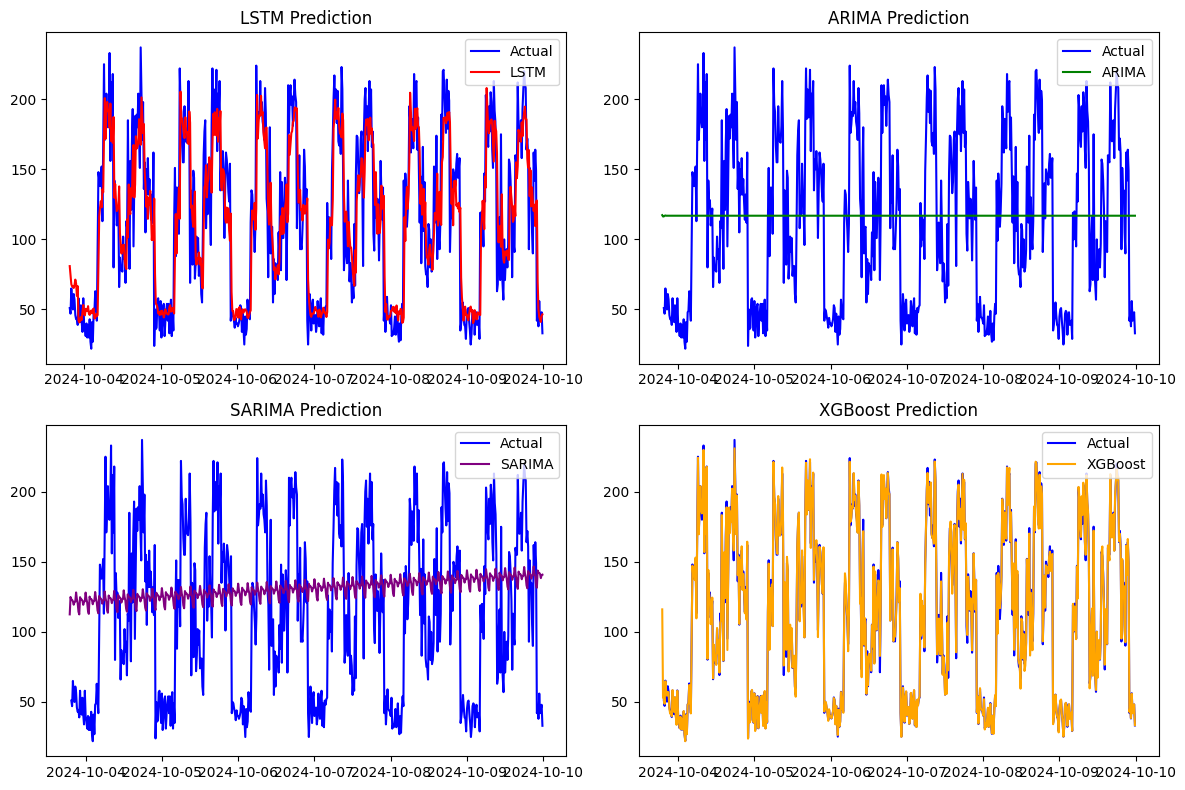

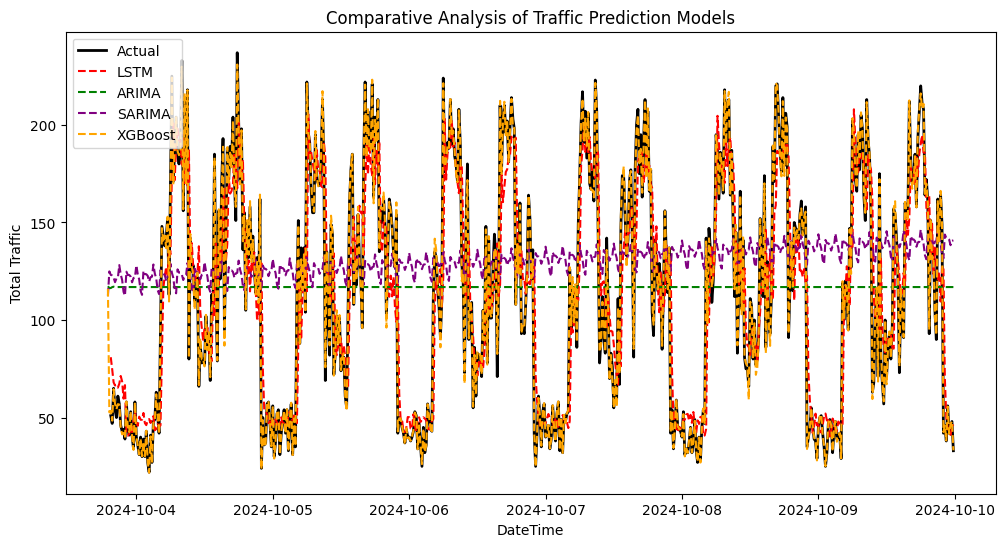

ValueError: Found input variables with inconsistent numbers of samples: [594, 596]

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Load dataset
file_path = '/Users/pranavashokdivekar/this_mac/Machine Learning/Traffic.csv'
df = pd.read_csv(file_path)

df['Date'] = '2024-10-' + df['Date'].astype(str)  
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  
df['Time'] = pd.to_datetime(df['Time'], format='%I:%M:%S %p', errors='coerce').dt.time
df['DateTime'] = df.apply(lambda row: pd.Timestamp.combine(row['Date'], row['Time']), axis=1)
df.set_index('DateTime', inplace=True)  

features = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount']
target = 'Total'

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df[target] = scaler.fit_transform(df[[target]])

# Prepare LSTM sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  
        y.append(data[i+seq_length, -1])    
    return np.array(X), np.array(y)

seq_length = 10  
data = df[features + [target]].values
X, y = create_sequences(data, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = X_train.reshape((X_train.shape[0], seq_length, len(features)))
X_test = X_test.reshape((X_test.shape[0], seq_length, len(features)))

# LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, len(features))),
    LSTM(50),
    Dense(25, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))
y_pred_lstm = model.predict(X_test)

# ARIMA Model
train_size = int(len(df) * 0.8)
train, test = df[target][:train_size], df[target][train_size:]

arima_model = ARIMA(train, order=(5, 1, 0))  
arima_result = arima_model.fit()
y_pred_arima = arima_result.forecast(len(test))

# SARIMA Model
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit()
y_pred_sarima = sarima_result.forecast(len(test))

# XGBoost Model
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(df[features], df[target], test_size=0.2, shuffle=False)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = xgb_model.predict(X_test_xgb)

# Convert back to original scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_lstm_actual = scaler.inverse_transform(y_pred_lstm)
y_pred_arima_actual = scaler.inverse_transform(y_pred_arima.values.reshape(-1, 1))
y_pred_sarima_actual = scaler.inverse_transform(y_pred_sarima.values.reshape(-1, 1))
y_pred_xgb_actual = scaler.inverse_transform(y_pred_xgb.reshape(-1, 1))

# Plot all models separately
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual", color='blue')
plt.plot(df.index[-len(y_pred_lstm_actual):], y_pred_lstm_actual, label="LSTM", color='red')
plt.title("LSTM Prediction")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual", color='blue')
plt.plot(df.index[-len(y_pred_arima_actual):], y_pred_arima_actual, label="ARIMA", color='green')
plt.title("ARIMA Prediction")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual", color='blue')
plt.plot(df.index[-len(y_pred_sarima_actual):], y_pred_sarima_actual, label="SARIMA", color='purple')
plt.title("SARIMA Prediction")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual", color='blue')
plt.plot(df.index[-len(y_pred_xgb_actual):], y_pred_xgb_actual, label="XGBoost", color='orange')
plt.title("XGBoost Prediction")
plt.legend()

plt.tight_layout()
plt.show()

# Combined plot
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual", color='black', linewidth=2)
plt.plot(df.index[-len(y_pred_lstm_actual):], y_pred_lstm_actual, label="LSTM", color='red', linestyle='dashed')
plt.plot(df.index[-len(y_pred_arima_actual):], y_pred_arima_actual, label="ARIMA", color='green', linestyle='dashed')
plt.plot(df.index[-len(y_pred_sarima_actual):], y_pred_sarima_actual, label="SARIMA", color='purple', linestyle='dashed')
plt.plot(df.index[-len(y_pred_xgb_actual):], y_pred_xgb_actual, label="XGBoost", color='orange', linestyle='dashed')

plt.xlabel("DateTime")
plt.ylabel("Total Traffic")
plt.title("Comparative Analysis of Traffic Prediction Models")
plt.legend()
plt.show()

# Model Performance Comparison
mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm_actual)
mse_arima = mean_squared_error(y_test_actual, y_pred_arima_actual)
mse_sarima = mean_squared_error(y_test_actual, y_pred_sarima_actual)
mse_xgb = mean_squared_error(y_test_actual, y_pred_xgb_actual)

print(f"LSTM MSE: {mse_lstm}")
print(f"ARIMA MSE: {mse_arima}")
print(f"SARIMA MSE: {mse_sarima}")
print(f"XGBoost MSE: {mse_xgb}")


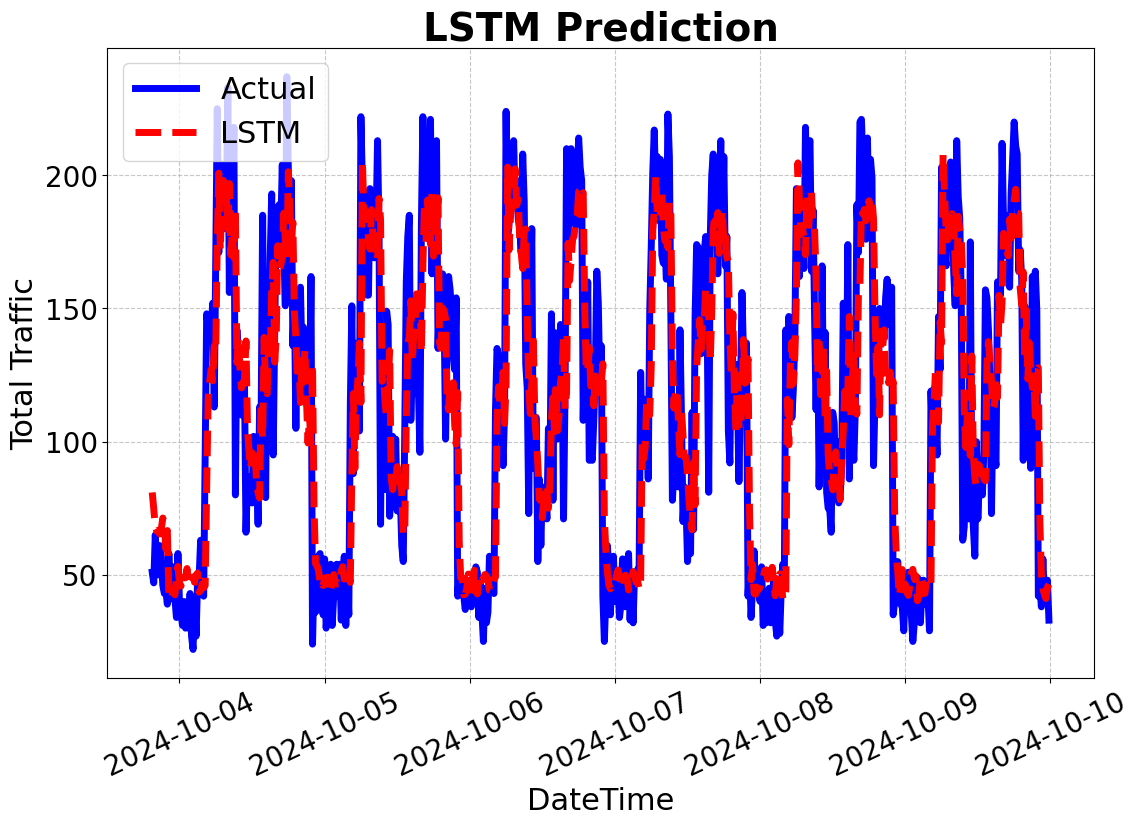

In [29]:
import matplotlib.pyplot as plt

# Set up an even larger figure
plt.figure(figsize=(28, 18))  # Increased size for maximum clarity

# Common parameters for all plots
line_width = 5
axis_fontsize = 22
title_fontsize = 28
legend_fontsize = 22
tick_fontsize = 20
grid_alpha = 0.7

# LSTM Plot
plt.subplot(2, 2, 1)
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual", color='blue', linewidth=line_width)
plt.plot(df.index[-len(y_pred_lstm_actual):], y_pred_lstm_actual, label="LSTM", color='red', linestyle='dashed', linewidth=line_width)
plt.title("LSTM Prediction", fontsize=title_fontsize, fontweight='bold')
plt.xlabel("DateTime", fontsize=axis_fontsize)
plt.ylabel("Total Traffic", fontsize=axis_fontsize)
plt.xticks(rotation=25, fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True, linestyle='--', alpha=grid_alpha)

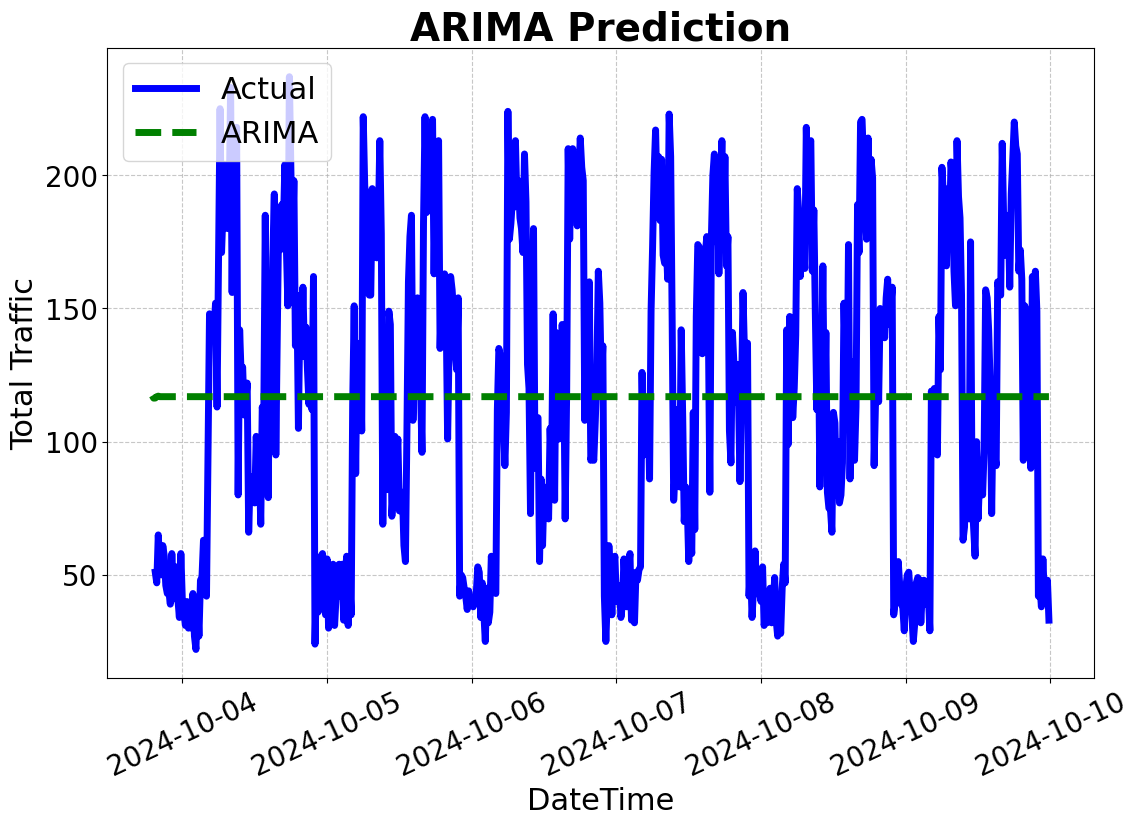

In [34]:
import matplotlib.pyplot as plt

# Set up an even larger figure
plt.figure(figsize=(28, 18))  # Increased size for maximum clarity

# Common parameters for all plots
line_width = 5
axis_fontsize = 22
title_fontsize = 28
legend_fontsize = 22
tick_fontsize = 20
grid_alpha = 0.7



# ARIMA Plot
plt.subplot(2, 2, 2)
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual", color='blue', linewidth=line_width)
plt.plot(df.index[-len(y_pred_arima_actual):], y_pred_arima_actual, label="ARIMA", color='green', linestyle='dashed', linewidth=line_width)
plt.title("ARIMA Prediction", fontsize=title_fontsize, fontweight='bold')
plt.xlabel("DateTime", fontsize=axis_fontsize)
plt.ylabel("Total Traffic", fontsize=axis_fontsize)
plt.xticks(rotation=25, fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True, linestyle='--', alpha=grid_alpha)

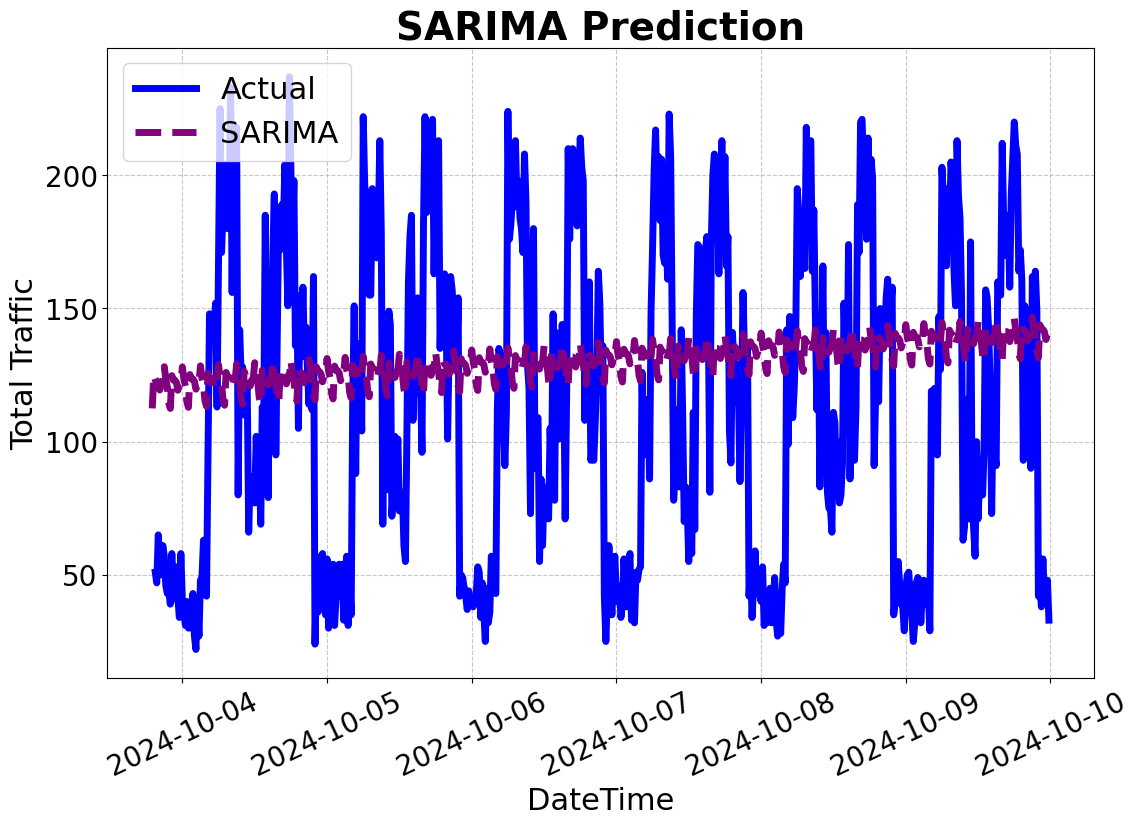

In [35]:
import matplotlib.pyplot as plt

# Set up an even larger figure
plt.figure(figsize=(28, 18))  # Increased size for maximum clarity

# Common parameters for all plots
line_width = 5
axis_fontsize = 22
title_fontsize = 28
legend_fontsize = 22
tick_fontsize = 20
grid_alpha = 0.7

plt.subplot(2, 2, 3)
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual", color='blue', linewidth=line_width)
plt.plot(df.index[-len(y_pred_sarima_actual):], y_pred_sarima_actual, label="SARIMA", color='purple', linestyle='dashed', linewidth=line_width)
plt.title("SARIMA Prediction", fontsize=title_fontsize, fontweight='bold')
plt.xlabel("DateTime", fontsize=axis_fontsize)
plt.ylabel("Total Traffic", fontsize=axis_fontsize)
plt.xticks(rotation=25, fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True, linestyle='--', alpha=grid_alpha)

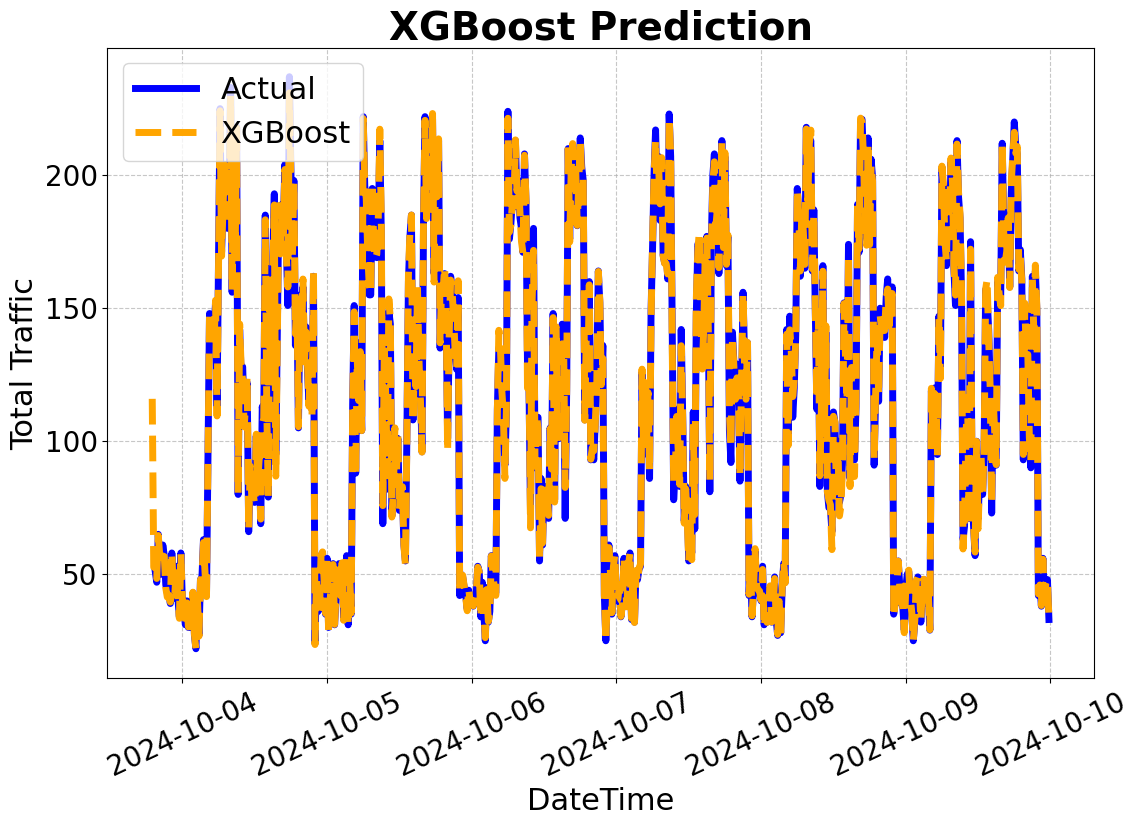

In [36]:
import matplotlib.pyplot as plt

# Set up an even larger figure
plt.figure(figsize=(28, 18))  # Increased size for maximum clarity

# Common parameters for all plots
line_width = 5
axis_fontsize = 22
title_fontsize = 28
legend_fontsize = 22
tick_fontsize = 20
grid_alpha = 0.7

plt.subplot(2, 2, 4)
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual", color='blue', linewidth=line_width)
plt.plot(df.index[-len(y_pred_xgb_actual):], y_pred_xgb_actual, label="XGBoost", color='orange', linestyle='dashed', linewidth=line_width)
plt.title("XGBoost Prediction", fontsize=title_fontsize, fontweight='bold')
plt.xlabel("DateTime", fontsize=axis_fontsize)
plt.ylabel("Total Traffic", fontsize=axis_fontsize)
plt.xticks(rotation=25, fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True, linestyle='--', alpha=grid_alpha)

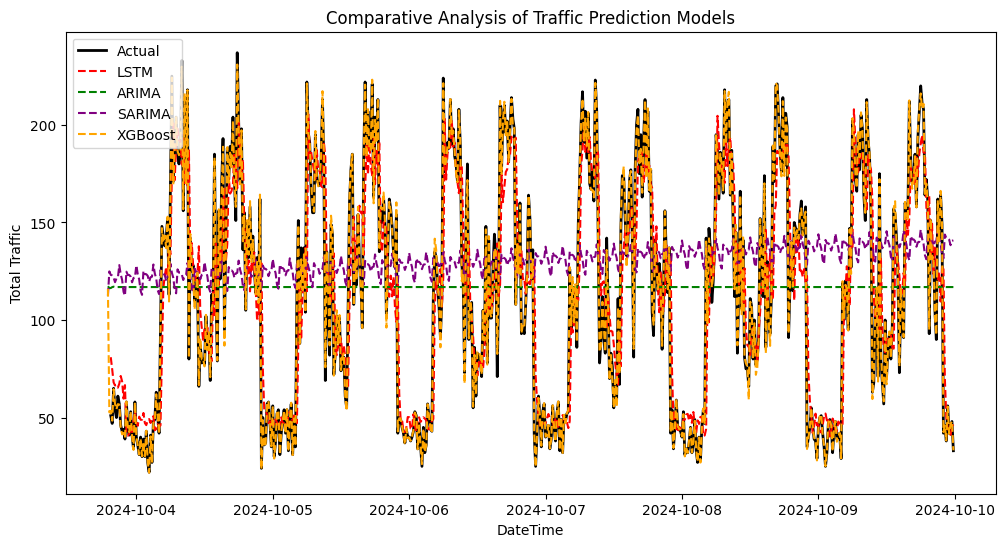

In [37]:
# Combined plot
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual", color='black', linewidth=2)
plt.plot(df.index[-len(y_pred_lstm_actual):], y_pred_lstm_actual, label="LSTM", color='red', linestyle='dashed')
plt.plot(df.index[-len(y_pred_arima_actual):], y_pred_arima_actual, label="ARIMA", color='green', linestyle='dashed')
plt.plot(df.index[-len(y_pred_sarima_actual):], y_pred_sarima_actual, label="SARIMA", color='purple', linestyle='dashed')
plt.plot(df.index[-len(y_pred_xgb_actual):], y_pred_xgb_actual, label="XGBoost", color='orange', linestyle='dashed')

plt.xlabel("DateTime")
plt.ylabel("Total Traffic")
plt.title("Comparative Analysis of Traffic Prediction Models")
plt.legend()
plt.show()

In [43]:
min_length = min(len(y_test_actual_class), len(y_pred_arima_class))

# Trim to minimum length
y_test_actual_class = y_test_actual_class[:min_length]
y_pred_arima_class = y_pred_arima_class[:min_length]
y_pred_sarima_class = y_pred_sarima_class[:min_length]
y_pred_xgb_class = y_pred_xgb_class[:min_length]
y_pred_lstm_class = y_pred_lstm_class[:min_length]

# Now run classification report again
from sklearn.metrics import classification_report

print("LSTM Classification Report:")
print(classification_report(y_test_actual_class, y_pred_lstm_class))

print("ARIMA Classification Report:")
print(classification_report(y_test_actual_class, y_pred_arima_class))

print("SARIMA Classification Report:")
print(classification_report(y_test_actual_class, y_pred_sarima_class))

print("XGBoost Classification Report:")
print(classification_report(y_test_actual_class, y_pred_xgb_class))


LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       298
           1       0.80      0.87      0.83       296

    accuracy                           0.83       594
   macro avg       0.83      0.83      0.83       594
weighted avg       0.83      0.83      0.83       594

ARIMA Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       298
           1       0.50      1.00      0.67       296

    accuracy                           0.50       594
   macro avg       0.25      0.50      0.33       594
weighted avg       0.25      0.50      0.33       594

SARIMA Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       298
           1       0.50      1.00      0.67       296

    accuracy                           0.50       594
   macro avg       0.75      0.51      0.

/Users/pranavashokdivekar/this_mac/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pranavashokdivekar/this_mac/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pranavashokdivekar/this_mac/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
file_path = '/Users/pranavashokdivekar/this_mac/Machine Learning/Traffic.csv'
df = pd.read_csv(file_path)

In [4]:
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal
...,...,...,...,...,...,...,...,...,...
2971,10:45:00 PM,9,Thursday,16,3,1,36,56,normal
2972,11:00:00 PM,9,Thursday,11,0,1,30,42,normal
2973,11:15:00 PM,9,Thursday,15,4,1,25,45,normal
2974,11:30:00 PM,9,Thursday,16,5,0,27,48,normal
